In [20]:
# Helper libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

1.13.1


In [21]:
# gpu stuff
%env CUDA_VISIBLE_DEVICES=0,1
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

env: CUDA_VISIBLE_DEVICES=0,1


In [22]:
tf.random.set_random_seed(123)
np.random.seed(123)

In [23]:
batch_size = 10

# Visualize data

In [24]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20, 
                                   zoom_range=0.15,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(224,224),
        batch_size=1,
        class_mode='categorical')

N_train = train_generator.n
N_val = validation_generator.n

Found 22794 images belonging to 9 classes.
Found 2537 images belonging to 9 classes.


In [42]:
class_names = sorted(list(train_generator.class_indices.keys()))
N_classes = len(class_names)
print(class_names)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']


['NV', 'NV', 'NV', 'NV', 'NV', 'MEL', 'NV', 'SCC', 'AK', 'VASC', 'NV', 'NV', 'BKL', 'BCC', 'VASC', 'AK', 'BCC', 'NV', 'BCC', 'BCC']


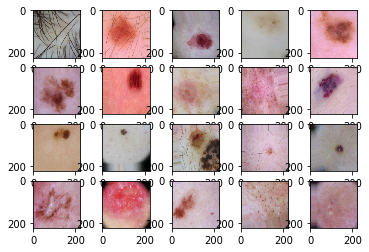

In [26]:
indices = np.random.randint(0,N_train, size=20)
batch = train_generator._get_batches_of_transformed_samples(indices)

images = batch[0]
labels = np.argmax(batch[1],axis=1)
label_names = [class_names[i] for i in labels]

for i,img in enumerate(images):
    plt.subplot(4,5,i+1)
    plt.imshow(img)
print(label_names)

# Confusion matrix

In [32]:
from keras.models import model_from_json
name = 'inception_resnet_dense'
# Model reconstruction from JSON file
with open('models/'+name+'_architecture.json', 'r') as f:
    model_best = model_from_json(f.read())

# Load weights into the new model
model_best.load_weights('models/'+name+'_weights.hdf5')

In [33]:
Y_pred = model_best.predict_generator(validation_generator, N_val//validation_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)

ValueError: Error when checking input: expected input_1 to have shape (299, 299, 3) but got array with shape (224, 224, 3)

In [36]:
Y_pred.shape

(2537, 8)

In [34]:
conf_mat = confusion_matrix(validation_generator.classes, y_pred)
report = classification_report(validation_generator.classes, y_pred, target_names=class_names)
print('Confusion Matrix')
print(conf_mat)
print('Classification Report')
print(report)

Confusion Matrix
[[  1   8   7   5  18  43   3   2   0]
 [ 10  44  44   7  63 152   7   6   0]
 [  3  27  41   3  44 134  10   1   0]
 [  1   3   5   0   4  10   0   1   0]
 [  7  64  51  11  95 207  12   6   0]
 [ 21 161 171  23 232 634  30  16   0]
 [  2   5   2   1  15  37   0   1   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   9   2   0   2  13   0   0   0]]
Classification Report
              precision    recall  f1-score   support

          AK       0.02      0.01      0.02        87
         BCC       0.14      0.13      0.13       333
         BKL       0.13      0.16      0.14       263
          DF       0.00      0.00      0.00        24
         MEL       0.20      0.21      0.21       453
          NV       0.52      0.49      0.50      1288
         SCC       0.00      0.00      0.00        63
         UNK       0.00      0.00      0.00         0
        VASC       0.00      0.00      0.00        26

   micro avg       0.32      0.32      0.32      2537
   macro avg 